In [1]:
import pandas as pd
import numpy as np

In [2]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

In [4]:
# Считываем данные:
data = pd.read_excel('consumer_inflation.xlsx')

In [5]:
# Преобразуем значения в более удобный формат и оставляем 1 столбец:
data = data.C_Inflation - 100

In [6]:
# Преобразуем индекс в формат datetime:
data.index = pd.date_range(start='2003-01-31', periods=len(data), freq='M')

Text(0, 0.5, 'В % к предыдущему месяцу')

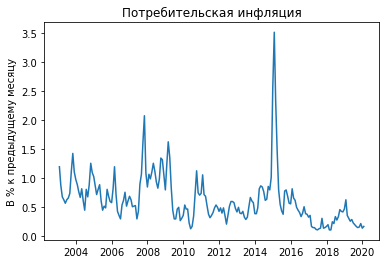

In [7]:
# График с динамикой показателя:
plt.plot(data)
plt.title('Потребительская инфляция')
plt.ylabel('В % к предыдущему месяцу')

In [8]:
# Вычисляем скользящее среднее и стандартное отклонение:
rolmean = data.rolling(window=12).mean()
rolstd = data.rolling(window=12).std()

Text(0.5, 1.0, 'Rolling Statistics')

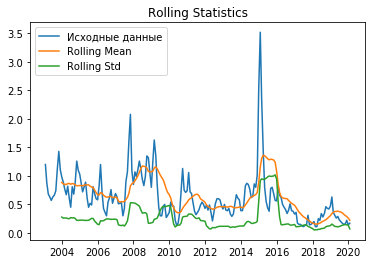

In [9]:
plt.plot(data, label='Исходные данные')
plt.plot(rolmean, label='Rolling Mean')
plt.plot(rolstd, label='Rolling Std')
plt.legend()
plt.title('Rolling Statistics')

In [10]:
print('Результат Dickey-Fuller test:')
dftest = adfuller(data, autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test_statistic', 'p-value', 'Lags_used', 'Number_of_observations'])

for key, value in dftest[4].items():
    dfoutput['Critical_value(%s)' % key] = value

dfoutput['AIC'] = dftest[5]
print(dfoutput)

Результат Dickey-Fuller test:
Test_statistic             -4.469491
p-value                     0.000223
Lags_used                   2.000000
Number_of_observations    202.000000
Critical_value(1%)         -3.463144
Critical_value(5%)         -2.875957
Critical_value(10%)        -2.574455
AIC                       -19.162573
dtype: float64


p-value меньше 0,05, показатель test statistic меньше критических значений, следовательно - данные удовлетворяют требованиям к stationary time series.

In [11]:
# Декомпозиция данных:
decomposition = seasonal_decompose(data)

observed = decomposition.observed
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

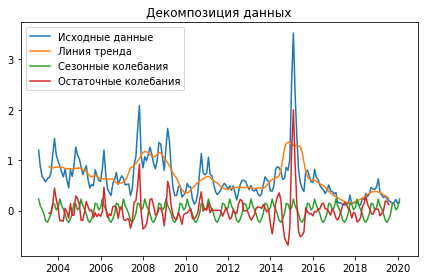

In [12]:
# Визуализация компонентов:
plt.plot(data.index, observed, label='Исходные данные')
plt.plot(data.index, trend, label='Линия тренда')
plt.plot(data.index, seasonal, label='Сезонные колебания')
plt.plot(data.index, residual, label='Остаточные колебания')
plt.legend()
plt.title('Декомпозиция данных')
plt.tight_layout()

Показатель инфляции имеет выраженную сезонность.
В долгосрочной перспективе линия тренда показывает умеренное снижение показателя, однако в отдельные периоды наблюдается скачкообразный рост инфляции, вызванный внешними факторами.

Text(0.5, 1.0, 'ACF')

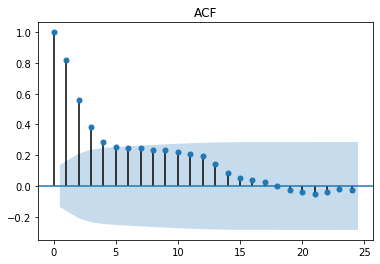

In [13]:
# Графики автокорреляции
plot_acf(data)
plt.title('ACF')

Text(0.5, 1.0, 'PACF')

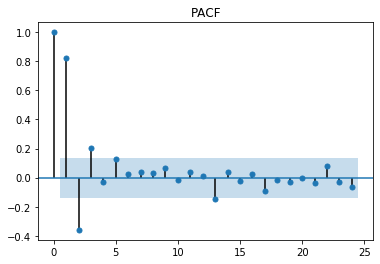

In [14]:
plot_pacf(data)
plt.title('PACF')

In [15]:
# Создаем модель SARIMA:
model_sarima = SARIMAX(data,
                       order=(1, 0, 1),
                       seasonal_order=(1, 0, 1, 12))

decomposition = model_sarima.fit(disp=False)
decomposition.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                        C_Inflation   No. Observations:                  205
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                  20.444
Date:                            Mon, 09 Mar 2020   AIC                            -30.888
Time:                                    15:08:39   BIC                            -14.273
Sample:                                01-31-2003   HQIC                           -24.167
                                     - 01-31-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7728      0.027     28.944      0.000       0.721       0.825
ma.L1          0.5348      0.054      9.852      0.000       0.428       0.641
ar.S.L12       0.9548      0.059     16.134      0.000       0.839       1.071
ma.S.L12      -0.8057      0.134     -6.018      0.000      -1.068      -0.543
sigma2         0.0460      0.003     14.759      0.000       0.040       0.052
===================================================================================
Ljung-Box (Q):                       21.90   Jarque-Bera (JB):              1304.52
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.23   Skew:                             1.32
Prob(H) (two-sided):                  0.40   Kurtosis:                        15.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

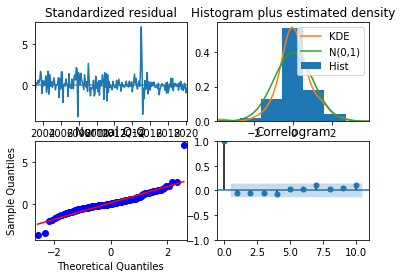

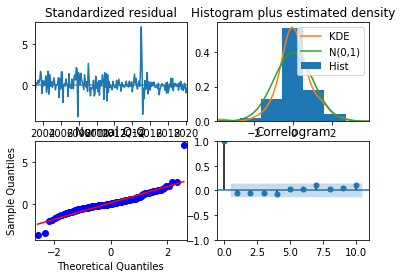

In [16]:
# Визуализируем параметры модели:
decomposition.plot_diagnostics()

In [17]:
# Прогноз на 12 месяцев вперед:
prediction = decomposition.get_forecast(steps=12)

In [18]:
# Доверительные интервалы прогноза:
prediction_int = prediction.conf_int()

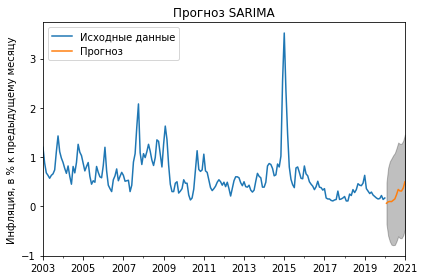

In [19]:
# Визуализируем прогноз:
ax = data.plot(label='Исходные данные')
prediction.predicted_mean.plot(ax=ax, label='Прогноз')
ax.fill_between(prediction_int.index,
                prediction_int.iloc[:, 0],
                prediction_int.iloc[:, 1], color='k', alpha=.25)
ax.set_ylabel('Инфляция, в % к предыдущему месяцу')
plt.legend()
plt.title('Прогноз SARIMA')
plt.tight_layout()

In [20]:
print('\nПоследние 12 фактических значений:\n', data[-12:])


Последние 12 фактических значений:
 2019-02-28    0.36
2019-03-31    0.31
2019-04-30    0.26
2019-05-31    0.29
2019-06-30    0.23
2019-07-31    0.20
2019-08-31    0.17
2019-09-30    0.15
2019-10-31    0.16
2019-11-30    0.22
2019-12-31    0.14
2020-01-31    0.17
Freq: M, Name: C_Inflation, dtype: float64


In [21]:
print('\nМин. и макс. значения прогноза SARIMA:\n', prediction_int.round(2))


Мин. и макс. значения прогноза SARIMA:
             lower C_Inflation  upper C_Inflation
2020-02-29              -0.36               0.48
2020-03-31              -0.60               0.78
2020-04-30              -0.71               0.91
2020-05-31              -0.78               0.97
2020-06-30              -0.79               1.04
2020-07-31              -0.78               1.08
2020-08-31              -0.71               1.18
2020-09-30              -0.61               1.30
2020-10-31              -0.64               1.27
2020-11-30              -0.65               1.27
2020-12-31              -0.59               1.33
2021-01-31              -0.46               1.46


In [22]:
forecast = decomposition.forecast(12)
print('\nБазовый прогноз SARIMA:\n', forecast.round(2))


Базовый прогноз SARIMA:
 2020-02-29    0.06
2020-03-31    0.09
2020-04-30    0.10
2020-05-31    0.10
2020-06-30    0.12
2020-07-31    0.15
2020-08-31    0.24
2020-09-30    0.34
2020-10-31    0.31
2020-11-30    0.31
2020-12-31    0.37
2021-01-31    0.50
Freq: M, dtype: float64


Text(0, 0.5, 'Инфляция, в % к предыдущему месяцу')

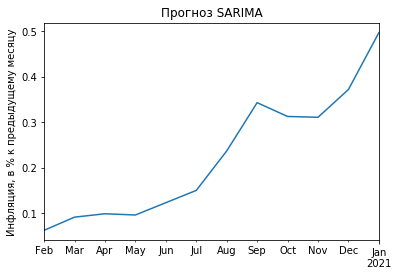

In [23]:
forecast.plot()
plt.title('Прогноз SARIMA')
plt.ylabel('Инфляция, в % к предыдущему месяцу')